# Morphological-opening (rolling minimum) baseline

In [1]:
# Cell 1: imports
import pandas as pd
import numpy as np
from scipy.ndimage import grey_opening
from scipy.signal  import find_peaks


In [2]:
# Cell 2: prompt for inputs
input_xlsx   = input("Path to input Excel: ").strip()
phys_window  = float(input("Baseline window length (same units as distance): ").strip())
height_thr   = float(input("Min rib height above baseline: ").strip())
output_xlsx  = input("Path for output Excel: ").strip()


Path to input Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_profiles.xlsx
Baseline window length (same units as distance): 31
Min rib height above baseline: 0.1
Path for output Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rollingwindow31.xlsx


In [3]:
# Cell 3: read sheets & init
sheets        = pd.read_excel(input_xlsx, sheet_name=None)
out_profiles  = {}
rib_summary   = []


In [4]:
# Cell 4: detrend + detect ribs
for name, df in sheets.items():
    if not {'distance','z'}.issubset(df.columns): 
        print(f"Skipping '{name}': missing cols"); continue

    d = df['distance']; spacing = d.diff().median()
    win_pts = int(phys_window/spacing) // 2 * 2 + 1
    
    z        = df['z'].values
    baseline = grey_opening(z, size=win_pts)
    zdt      = z - baseline

    peaks, _ = find_peaks(zdt, height=height_thr)
    df['baseline']    = baseline
    df['z_detrended'] = zdt
    df['is_rib']      = False
    df.loc[peaks, 'is_rib'] = True

    rib_summary += [
        {'profile': name,
         'distance': d.iat[i],
         'rib_height': zdt[i]}
        for i in peaks
    ]
    out_profiles[name] = df


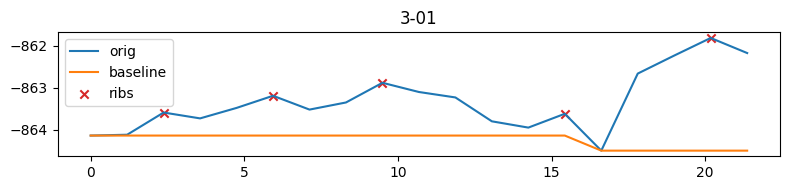

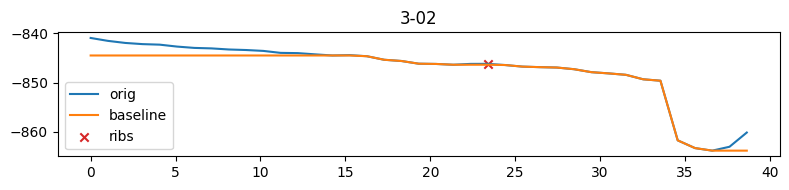

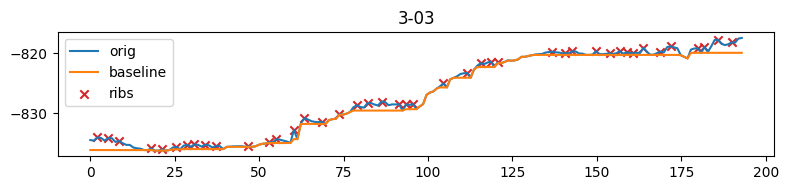

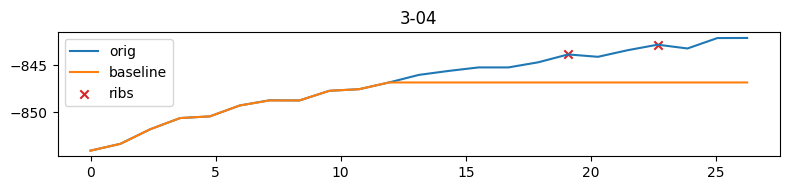

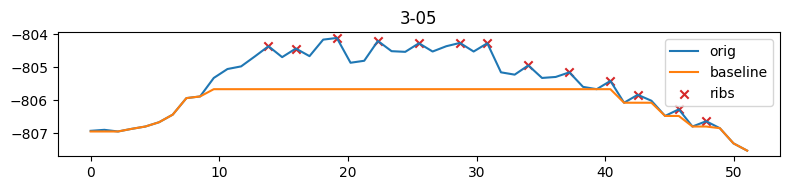

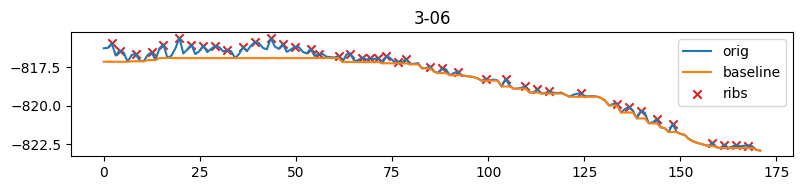

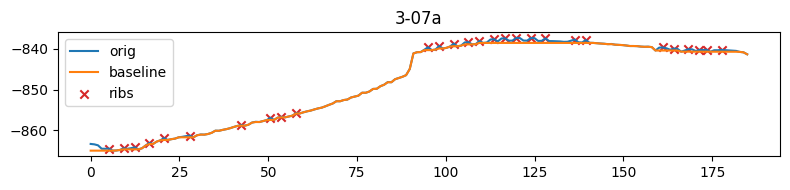

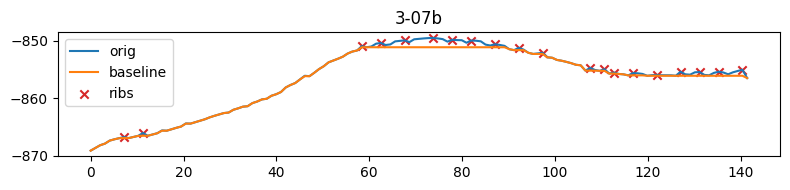

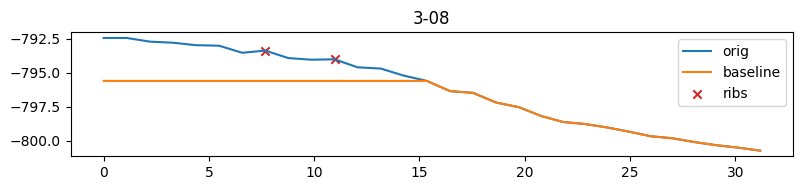

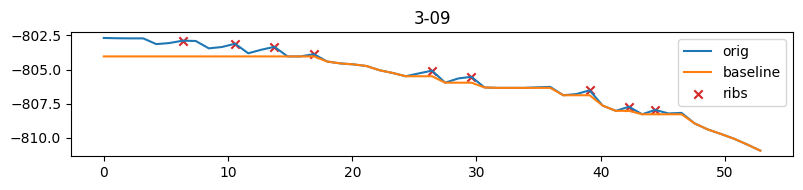

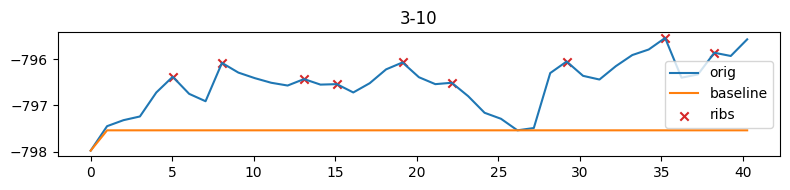

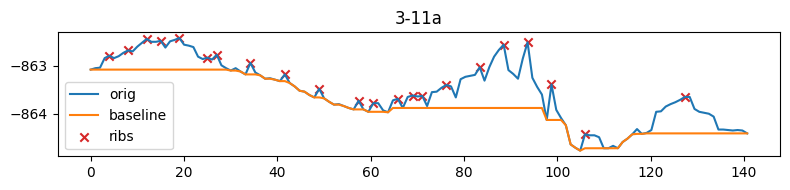

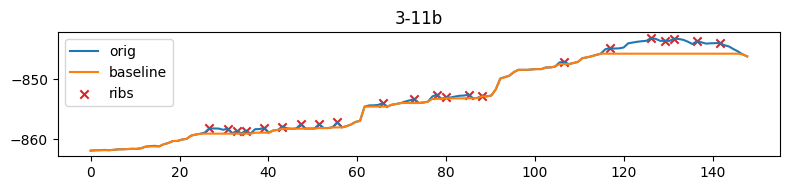

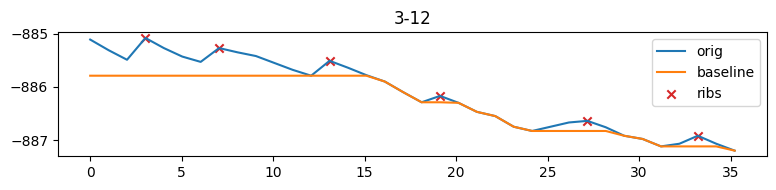

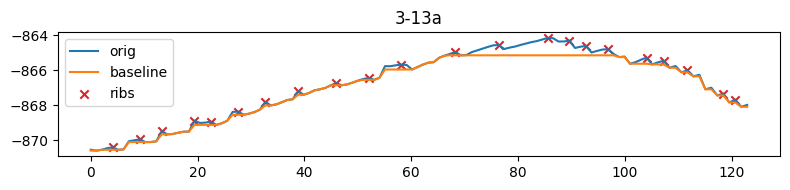

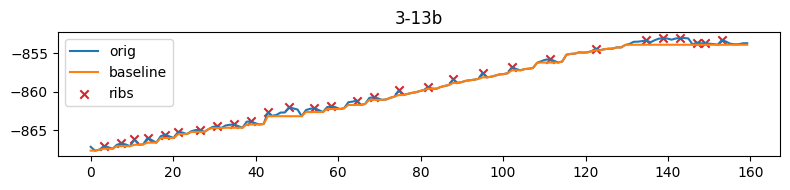

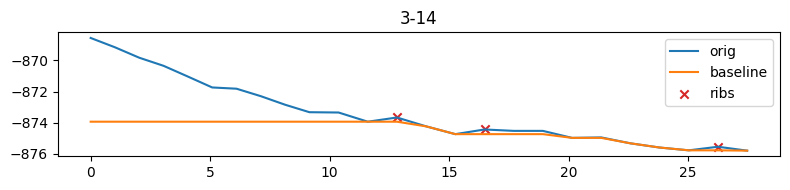

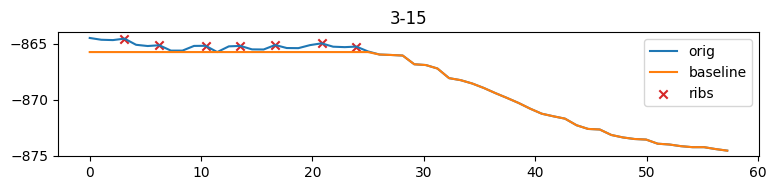

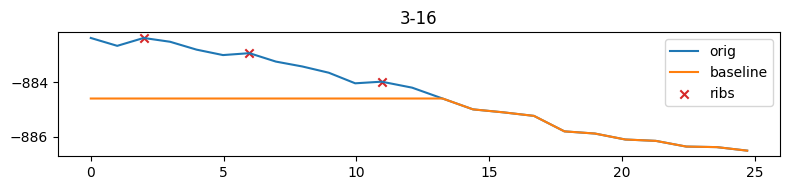

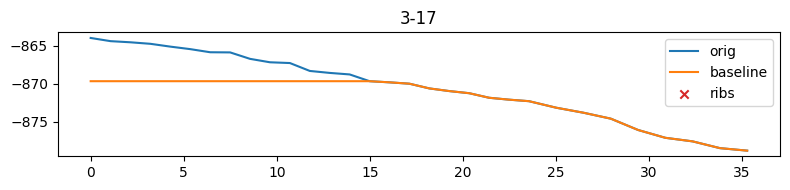

In [5]:
# Cell 5: quick plots for each profile
import matplotlib.pyplot as plt

for name, df in out_profiles.items():
    s = df['distance'].values
    z = df['z'].values
    baseline = df['baseline'].values
    zdt = df['z_detrended'].values
    peaks = np.flatnonzero(df['is_rib'])

    plt.figure(figsize=(8,2))
    plt.plot(s, z,      label='orig')
    plt.plot(s, baseline, label='baseline')
    plt.scatter(s[peaks], zdt[peaks] + baseline[peaks], marker='x', color='C3', label='ribs')
    plt.title(name); plt.legend(); plt.tight_layout()
    plt.show()


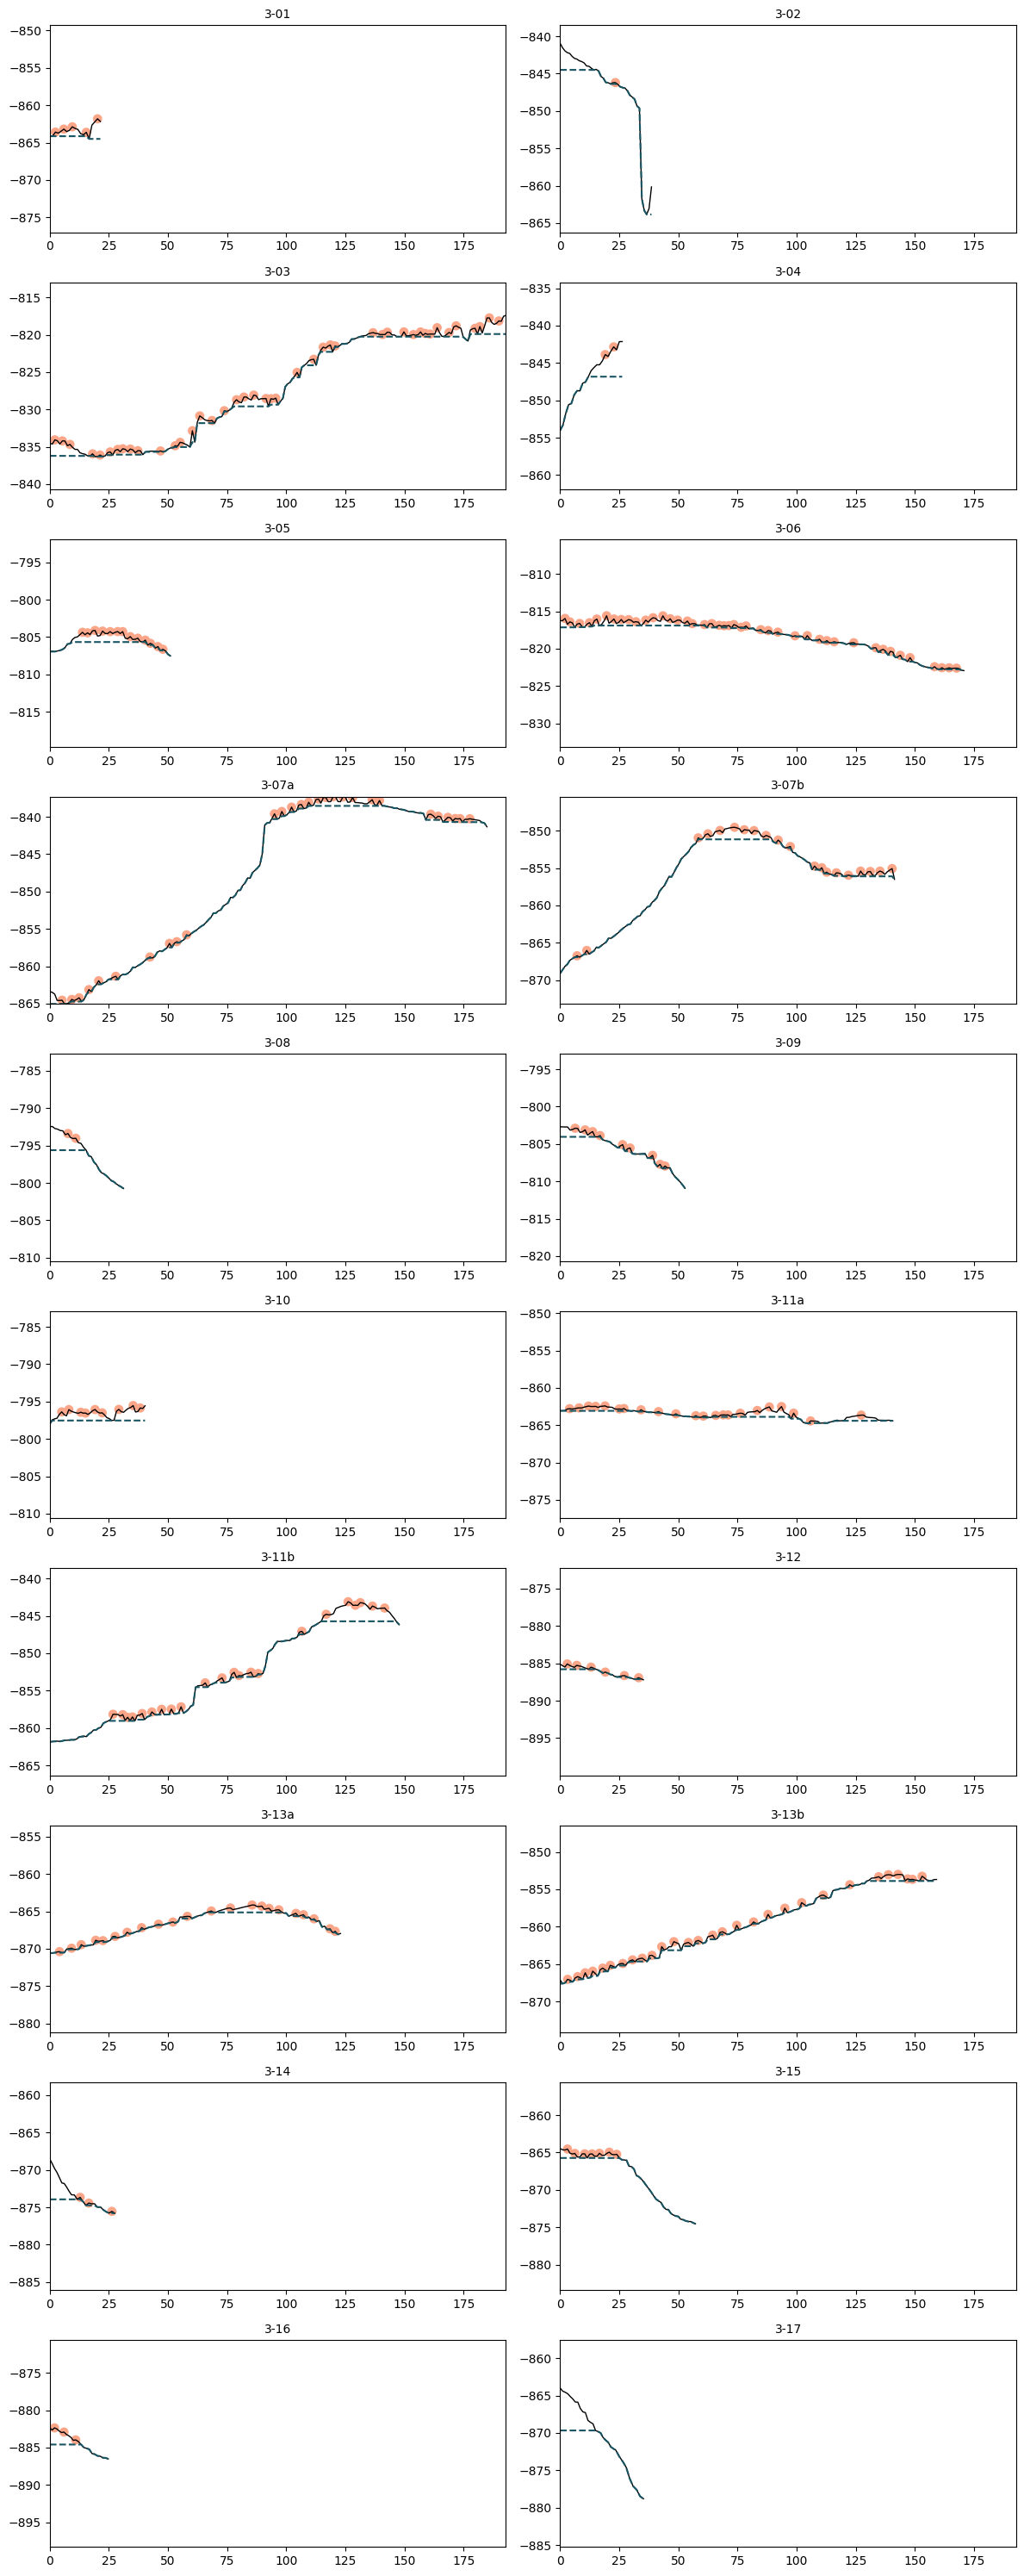

In [6]:
# Cell 6: combined plot → one PNG, black profiles; batlow baseline & filled‐circle ribs
import matplotlib.pyplot as plt
import numpy as np
import cmcrameri.cm as cmr

# 1) compute max individual z‐range
z_ranges = [(df['z'].max() - df['z'].min()) for df in out_profiles.values()]
max_range = max(z_ranges)

# 2) compute global x‐limits
all_s = np.hstack([df['distance'].values for df in out_profiles.values()])
x_min, x_max = all_s.min(), all_s.max()

# 3) prepare figure grid
n    = len(out_profiles)
cols = 2
rows = (n + cols - 1)//cols
fig, axes = plt.subplots(rows, cols, figsize=(12, rows*3))
axs = axes.flatten()

# 4) pick two batlow colors
cmap     = cmr.batlow
base_col = cmap(0.2)  # baseline color
rib_col  = cmap(0.8)  # rib fill color

# 5) plot each profile with uniform axes
for ax, (name, df) in zip(axs, out_profiles.items()):
    s    = df['distance'].values
    z    = df['z'].values
    base = df['baseline'].values
    zdt  = df['z_detrended'].values
    peaks = np.flatnonzero(df['is_rib'])

    # ribs: filled circles behind
    ax.scatter(s[peaks], base[peaks] + zdt[peaks],
               marker='o',
               s=60,
               facecolor=rib_col,
               edgecolor='none',
               zorder=1)

    # profile & baseline on top
    ax.plot(s, z,      color='black', linewidth=1, zorder=2)
    ax.plot(s, base,   linestyle='--', color=base_col,    zorder=2)

    # uniform axes
    mid = (z.max() + z.min()) / 2
    ax.set_ylim(mid - max_range/2, mid + max_range/2)
    ax.set_xlim(x_min, x_max)
    ax.set_title(name, fontsize=10)

# 6) turn off any unused subplots
for ax in axs[n:]:
    ax.axis('off')

# 7) finalize & save
fig.tight_layout()
fig.savefig('all_profiles_ribs.png', dpi=300)


In [7]:
# Cell 6: write results
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as w:
    for name, df in out_profiles.items():
        df.to_excel(w, sheet_name=name, index=False)
    pd.DataFrame(rib_summary).to_excel(w, sheet_name='rib_summary', index=False)

print("✔ Done – results in", output_xlsx)


✔ Done – results in /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rollingwindow31.xlsx


# Rib details

In [12]:
# Cell 1: imports
import pandas as pd
import numpy as np


In [14]:
# Cell 2: prompt for input/output
input_xlsx  = input("Path to input Excel: ").strip()
output_xlsx = input("Path for output Excel: ").strip()


Path to input Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rolloingwindow7.xlsx
Path for output Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rolloingwindow7_details.xlsx


In [15]:
# Cell 3: read all sheets & init
sheets          = pd.read_excel(input_xlsx, sheet_name=None)
summary_sheets  = {}



In [16]:
# Cell 4: build per‑sheet summaries
for name, df in sheets.items():
    if 'is_rib' not in df.columns: 
        continue
    ribs = df[df['is_rib']].sort_values('distance').reset_index(drop=True)
    if ribs.empty:
        continue
    ribs = ribs.assign(
        rib_number = ribs.index + 1,
        spacing    = ribs['distance'].shift(-1) - ribs['distance'],
        height     = ribs['z_detrended']
    )
    summary_sheets[name] = ribs[[
        'rib_number','lat','long','z','spacing','height'
    ]].rename(columns={
        'lat':'latitude',
        'long':'longitude',
        'z':'water_depth'
    })


In [17]:
# Cell 5: write out only summary sheets
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as w:
    for name, df_sum in summary_sheets.items():
        df_sum.to_excel(w, sheet_name=name, index=False)
print("✔ Done – per‑sheet summaries written to", output_xlsx)


✔ Done – per‑sheet summaries written to /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rolloingwindow7_details.xlsx


# Summary Statistics

In [18]:
# Cell 1: imports
import pandas as pd


In [19]:
# Cell 2: prompt for input/output
input_xlsx  = input("Path to rib_summary Excel: ").strip()
output_xlsx = input("Path for summary stats Excel: ").strip()


Path to rib_summary Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rolloingwindow7_details.xlsx
Path for summary stats Excel: /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rolloingwindow7_stats.xlsx


In [20]:
# Cell 3: read all rib_summary sheets
details = pd.read_excel(input_xlsx, sheet_name=None)


In [21]:
# Cell 4: compute per‑sheet statistics
summary_sheets = {}
for name, df in details.items():
    s = df['spacing'].dropna()
    h = df['height'].dropna()
    summary_sheets[name] = pd.DataFrame({
        'mean_spacing': [s.mean()],
        'std_spacing':  [s.std()],
        'min_spacing':  [s.min()],
        'max_spacing':  [s.max()],
        'mean_height':  [h.mean()],
        'std_height':   [h.std()],
        'min_height':   [h.min()],
        'max_height':   [h.max()]
    })


In [22]:
# Cell 5: compute overall dataset statistics
num_profiles = len(details)
ribs_counts  = [len(df) for df in details.values()]
avg_ribs     = sum(ribs_counts) / num_profiles
all_df       = pd.concat(details.values(), ignore_index=True)
s_all        = all_df['spacing'].dropna()
h_all        = all_df['height'].dropna()
overall = pd.DataFrame({
    'avg_ribs_per_profile': [avg_ribs],
    'mean_spacing':         [s_all.mean()],
    'std_spacing':          [s_all.std()],
    'min_spacing':          [s_all.min()],
    'max_spacing':          [s_all.max()],
    'mean_height':          [h_all.mean()],
    'std_height':           [h_all.std()],
    'min_height':           [h_all.min()],
    'max_height':           [h_all.max()]
})


In [23]:
# Cell 6: write all summaries to Excel
with pd.ExcelWriter(output_xlsx, engine='openpyxl') as writer:
    for name, df_sum in summary_sheets.items():
        df_sum.to_excel(writer, sheet_name=name, index=False)
    overall.to_excel(writer, sheet_name='overall_summary', index=False)
print("✔ Done – statistics written to", output_xlsx)


✔ Done – statistics written to /Users/alehrmann/Documents/Research_files/West_Antarctica/Amundsen_Sea/Dotson/Ribs/profiles/Drumlin3 rib profiles/Drumlin3_rib_rolloingwindow7_stats.xlsx
